# Deepfake Emotion Analysis with Py-Feat ResMaskNet

This notebook implements an end-to-end facial emotion analysis pipeline on deepfake images, combining:

- **Py-Feat (ResMaskNet)** for face detection, feature extraction, and probabilistic emotion classification  
- **Custom significance scoring** to identify the most relevant face(s) per image  

## Initial Considerations: SVM vs. ResMaskNet

We evaluated Py-Feat’s alternative SVM classifier but opted for its deep learning–based ResMaskNet (ResNet-backboned) because:

- **Higher accuracy**: ResMaskNet achieves an average F1 of ~0.55 on AffectNet versus ~0.39 for linear SVM [1]
- **Probabilistic outputs** enable richer downstream analysis  
- **Residual masking blocks** focus on key facial regions for finer-grained emotion cues  

## Pipeline Overview

1. **Data Loading & Filtering**   
   - Keep only deduplicated images i.e. "originals" (`is_kept_image == True`)  

2. **Face Detection & Emotion Extraction**  
   - Instantiate a `Detector()` based on Py-Feat  
   - Run `.detect_image()` on each image → `Fex` objects  
   - Convert to DataFrame (`to_df()`), append `incident_id` & path  

3. **Significance Scoring**  
   - Compute each face’s **area** and **centrality** within the frame  
   - Weight and combine these into a single “significance” score  
   - Retain only top face(s) per image for emotion summarization  

4. **Emotion Aggregation & Summarization**  
   - Merge significant-face emotion scores back into master table  
   - Compute per-incident mean scores, then extract **dominant** and **secondary** emotions  

5. **Results Export**  
   - Save both raw detection results and final emotion-enriched CSVs back to Drive  

## Special Focus: Face Significance

By weighting face **size** and **proximity to image center**, we:

- Filter out small or peripheral detections  
- Concentrate emotion analysis on the most likely subject(s)  

Thresholds ensure at least one face per image is scored, with multi-face images retaining the top two if similarly prominent.

## References

[1] J. H. Cheong, E. Jolly, T. Xie, S. Byrne, M. Kenney, and L. J. Chang, “Py-Feat: Python Facial Expression Analysis Toolbox,” *arXiv*, Apr. 2023, arXiv:2104.03509. [Online]. Available: https://arxiv.org/abs/2104.03509


In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install numpy==1.23.5
import numpy as np

# Monkey-patch: if np.dtypes.Int64DType exists, replace it with np.int64.
if hasattr(np, 'dtypes') and hasattr(np.dtypes, 'Int64DType'):
    np.dtypes.Int64DType = np.int64

print("NumPy version:", np.__version__)

NumPy version: 1.23.5


In [3]:
import scipy.integrate as integrate
# Patch: if simps is missing, assign it to simpson
if not hasattr(integrate, 'simps'):
    from scipy.integrate import simpson
    integrate.simps = simpson

In [6]:
!pip install -q py-feat

In [7]:
import os
import re
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

plt.rcParams.update({
    "figure.dpi":            120,
    "font.size":             11,   # base font size
    "axes.titlesize":        14,   # subplot title
    "axes.labelsize":        12,
    "xtick.labelsize":       10,
    "ytick.labelsize":       10,
    "legend.fontsize":       10,
    "figure.titlesize":      16,   # overall figure title
    "axes.titlepad":         6,    # space between axes and title
    "axes.labelpad":         4,
    "legend.title_fontsize": 11,
})
sns.set_style("whitegrid")

from PIL import Image
import cv2
import glob

from tqdm import tqdm

from feat import Detector
from feat.plotting import imshow
from feat.utils.io import read_feat

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
csv_path = "/content/drive/MyDrive/CSM 2025/data/image_level_data_with_resnet_duplicates.csv"
df_raw = pd.read_csv(csv_path)
df = df_raw[df_raw['is_kept_image'] == True]

display(df.head())

Unnamed: 0 report_id  date_coded  \
0          23       105  2023-11-19   
1          24       106  2023-11-19   
2          27       108  2023-11-19   
3          25       107  2023-11-19   
4          29       110  2023-11-19   

                                                 url  \
0  https://twitter.com/nocontextfre/status/163830...   
1  https://twitter.com/nocontextfre/status/163830...   
2  https://twitter.com/Cyphertux/status/163856597...   
3  https://twitter.com/nocontextfre/status/163830...   
4  https://twitter.com/Cyphertux/status/163858617...   

                                                file screenshot date_posted  \
0  105.jpg (https://v5.airtableusercontent.com/v3...        NaN  2023-03-21   
1  106.jpg (https://v5.airtableusercontent.com/v3...        NaN  2023-03-21   
2  108.jpg (https://v5.airtableusercontent.com/v3...        NaN  2023-03-22   
3  107.jpg (https://v5.airtableusercontent.com/v3...        NaN  2023-03-21   
4  110.jpg (https://v5.airtableusercontent.com/v3...        NaN  2023-03-22   

  format  transcript                                    summary_content  ...  \
0  image         NaN  President Macron is running through the street...  ...   
1  image         NaN  Macron is near unruly crowds who are trying to...  ...   
2  image         NaN  Macron is posing in a street in front of a bur...  ...   
3  image         NaN  President Macron is running through a cloud of...  ...   
4  image         NaN  Macron is standing in a street, in front of cr...  ...   

     year total_engagement incident_id base_incident_id_original  \
0  2023.0        3344230.0         121                       121   
1  2023.0        3344230.0         122                       122   
2  2023.0          53863.0         124                       124   
3  2023.0        3344230.0         123                       123   
4  2023.0          43408.0         126                       126   

                                     image_full_path is_kept_image  \
0  /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
1  /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
2  /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
3  /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
4  /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   

  is_duplicate_version  duplicate_of_incident_id  duplicate_set_id  \
0                False                       NaN               NaN   
1                False                       NaN               1.0   
2                False                       NaN               2.0   
3                False                       NaN               3.0   
4                False                       NaN               NaN   

   represents_images  
0                NaN  
1            ['131']  
2            ['219']  
3            ['132']  
4                NaN  

[5 rows x 68 columns]

100%|██████████| 1/1 [00:12<00:00, 12.40s/it]


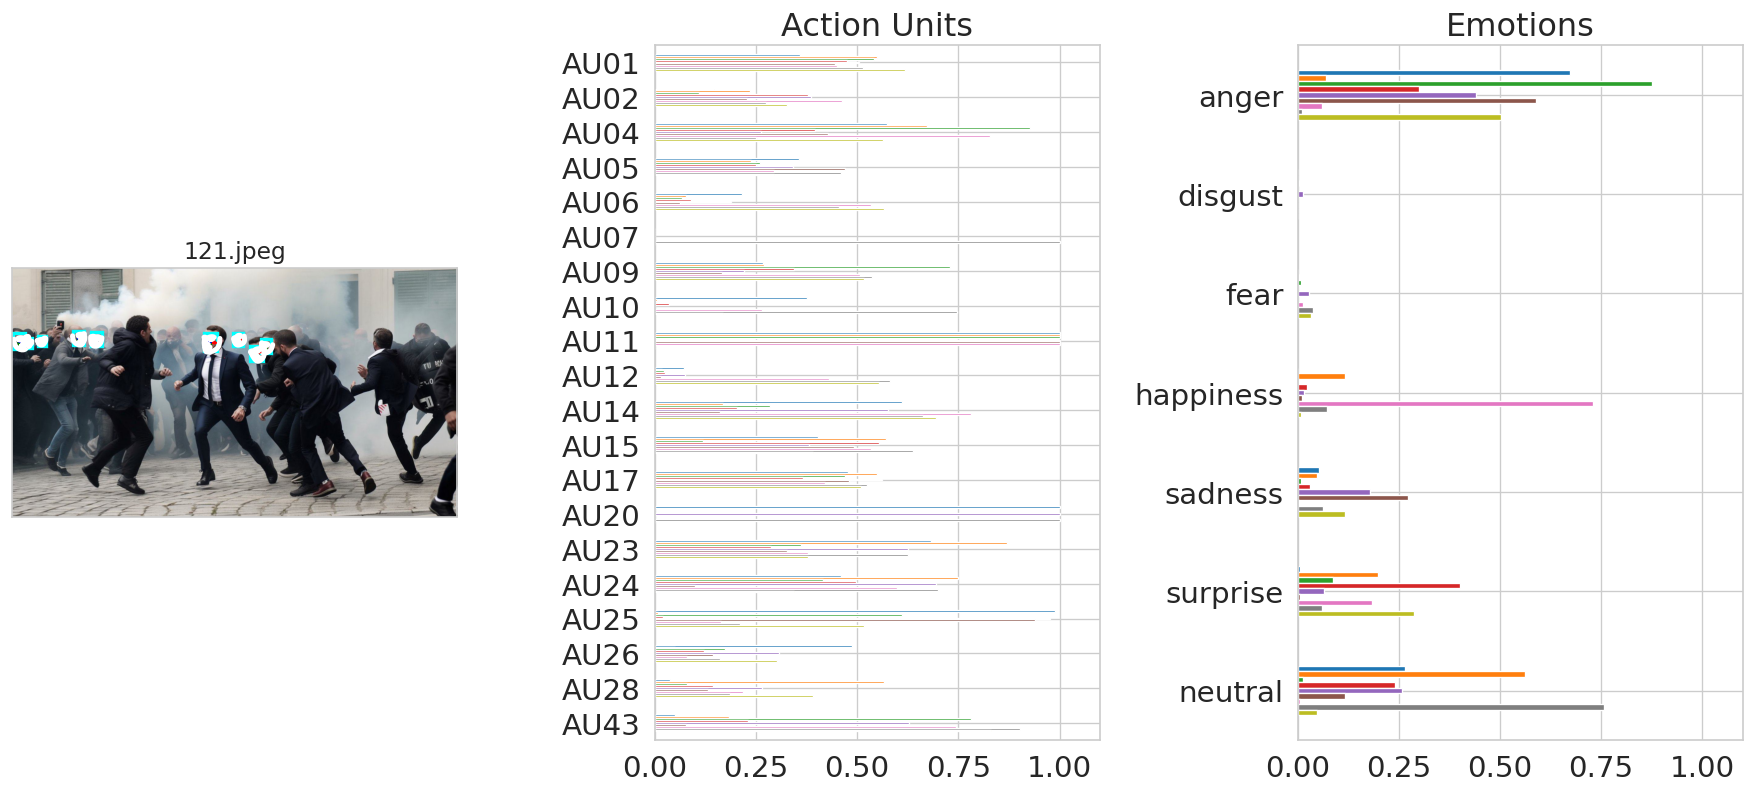

In [10]:
detector = Detector()
single_face_img_path = df['image_full_path'][0]
single_face_prediction = detector.detect_image(single_face_img_path, data_type="image")
figs = single_face_prediction.plot_detections(poses=True)

In [11]:
all_detections_dfs = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing images"):
    incident_id = row['incident_id']
    if not isinstance(incident_id, str):
        incident_id = str(incident_id)

    image_path = str(row['image_full_path'])

    try:
        # Process the image and get the detection results as a Fex object
        fex = detector.detect_image(image_path, data_type="image")
        fex_df = fex.to_df() if hasattr(fex, "to_df") else pd.DataFrame(fex)

        if not fex_df.empty:
            fex_df["incident_id"] = incident_id
            fex_df["image_path"] = image_path
            all_detections_dfs.append(fex_df)
        else:
            print(f"No faces detected in image: {incident_id}")

    except Exception as e:
        print(f"Error processing image {incident_id}: {e}")

if all_detections_dfs:
    results_df = pd.concat(all_detections_dfs, ignore_index=True)
    print(f"Shape of the aggregated results DataFrame: {results_df.shape}")
else:
    results_df = pd.DataFrame()
    print("No detections to aggregate.")

output_csv_path = "/content/drive/MyDrive/CSM 2025/data/results_res_final.csv"
results_df.to_csv(output_csv_path, index=False)
print(f"Aggregated results saved to {output_csv_path}")

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:root:Warning: NO FACE is detected

  0%|          | 0/1 [00:00<?, ?it/s]WAR

Shape of the aggregated results DataFrame: (818, 688)
Aggregated results saved to /content/drive/MyDrive/CSM 2025/data/results_res_final.csv


In [12]:
df_raw = pd.read_csv("/content/drive/MyDrive/CSM 2025/data/image_level_data_with_resnet_duplicates.csv")
pdid_master = df_raw[df_raw['is_kept_image'] == True]
display(pdid_master.head())

res_prediction = read_feat("/content/drive/MyDrive/CSM 2025/data/results_res_final.csv")

pdid_face = pd.concat([
    pd.Series(res_prediction.incident_id, name="incident_id")
      .astype(str)
      .str.extract(r"(\d+)", expand=False)
      .astype(int),
    # Emotion scores
    pd.DataFrame(res_prediction.emotions),
    # AU probabilities
    pd.DataFrame(res_prediction.aus),
    # Bounding boxes
    pd.DataFrame(res_prediction.faceboxes)
], axis=1)
display(pdid_face.head())

Unnamed: 0 report_id  date_coded  \
0          23       105  2023-11-19   
1          24       106  2023-11-19   
2          27       108  2023-11-19   
3          25       107  2023-11-19   
4          29       110  2023-11-19   

                                                 url  \
0  https://twitter.com/nocontextfre/status/163830...   
1  https://twitter.com/nocontextfre/status/163830...   
2  https://twitter.com/Cyphertux/status/163856597...   
3  https://twitter.com/nocontextfre/status/163830...   
4  https://twitter.com/Cyphertux/status/163858617...   

                                                file screenshot date_posted  \
0  105.jpg (https://v5.airtableusercontent.com/v3...        NaN  2023-03-21   
1  106.jpg (https://v5.airtableusercontent.com/v3...        NaN  2023-03-21   
2  108.jpg (https://v5.airtableusercontent.com/v3...        NaN  2023-03-22   
3  107.jpg (https://v5.airtableusercontent.com/v3...        NaN  2023-03-21   
4  110.jpg (https://v5.airtableusercontent.com/v3...        NaN  2023-03-22   

  format  transcript                                    summary_content  ...  \
0  image         NaN  President Macron is running through the street...  ...   
1  image         NaN  Macron is near unruly crowds who are trying to...  ...   
2  image         NaN  Macron is posing in a street in front of a bur...  ...   
3  image         NaN  President Macron is running through a cloud of...  ...   
4  image         NaN  Macron is standing in a street, in front of cr...  ...   

     year total_engagement incident_id base_incident_id_original  \
0  2023.0        3344230.0         121                       121   
1  2023.0        3344230.0         122                       122   
2  2023.0          53863.0         124                       124   
3  2023.0        3344230.0         123                       123   
4  2023.0          43408.0         126                       126   

                                     image_full_path is_kept_image  \
0  /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
1  /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
2  /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
3  /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
4  /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   

  is_duplicate_version  duplicate_of_incident_id  duplicate_set_id  \
0                False                       NaN               NaN   
1                False                       NaN               1.0   
2                False                       NaN               2.0   
3                False                       NaN               3.0   
4                False                       NaN               NaN   

   represents_images  
0                NaN  
1            ['131']  
2            ['219']  
3            ['132']  
4                NaN  

[5 rows x 68 columns]

incident_id     anger   disgust      fear  happiness   sadness  surprise  \
0          121  0.671928  0.002133  0.000717   0.001650  0.052514  0.004731   
1          121  0.071099  0.000413  0.003487   0.118215  0.047202  0.198702   
2          121  0.875416  0.004302  0.007699   0.003508  0.008090  0.086939   
3          121  0.299641  0.000257  0.001187   0.023918  0.031459  0.402180   
4          121  0.441652  0.013542  0.028830   0.014825  0.179548  0.064477   

    neutral      AU01      AU02  ...      AU24      AU25      AU26      AU28  \
0  0.266327  0.358529  0.145450  ...  0.459598  0.989144  0.487215  0.037279   
1  0.560882  0.550124  0.234444  ...  0.749058  0.006705  0.050428  0.565756   
2  0.014046  0.542718  0.108947  ...  0.415644  0.611261  0.172622  0.080010   
3  0.241359  0.473975  0.377596  ...  0.498040  0.019445  0.120831  0.142775   
4  0.257127  0.504892  0.384673  ...  0.695296  0.976024  0.307611  0.264730   

       AU43   FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  
0  0.051131    3.451349  213.545944      37.752706       50.405132   0.983851  
1  0.182551  257.739892  208.228370      34.768116       47.455298   0.972560  
2  0.781449  626.335611  212.017580      42.904338       59.240093   0.953238  
3  0.230653  197.392183  206.392027      36.983752       46.129608   0.941640  
4  0.626820  813.323499  231.539923      32.357567       45.568057   0.930634  

[5 rows x 33 columns]

In [13]:
def _score_faces(df_faces, img_w, img_h,
                 w_area=0.6, w_center=0.4):
    """
    Compute a significance score for one photo (one incident_id).

    Parameters
    ----------
    df_faces : DataFrame containing one row per face of this photo
               and bounding-box columns FaceRectX, FaceRectY,
               FaceRectWidth, FaceRectHeight.
    img_w, img_h : original image dimensions in pixels
                   (available via detector, or read by PIL.Image)
    w_area, w_center : weights that trade off size vs. centrality.
    """
    # --- size component ----------------------------------------------------
    areas = df_faces.FaceRectWidth * df_faces.FaceRectHeight
    area_score = areas / areas.max()                     # range [0,1]

    # --- centrality component ---------------------------------------------
    cx_face = df_faces.FaceRectX + df_faces.FaceRectWidth  / 2
    cy_face = df_faces.FaceRectY + df_faces.FaceRectHeight / 2
    cx_img, cy_img = img_w / 2, img_h / 2

    dist = np.sqrt((cx_face - cx_img)**2 + (cy_face - cy_img)**2)
    max_dist = np.sqrt((cx_img)**2 + (cy_img)**2)        # corner distance
    center_score = 1 - (dist / max_dist)                 # 1 = dead centre

    # --- combined score ----------------------------------------------------
    return w_area * area_score + w_center * center_score


img_dims = {}
for row in pdid_master.itertuples():
    pattern = f"{row.image_full_path}" # Ensure image_full_path is correct
    matches = glob.glob(pattern)
    if matches:
        img_path = matches[0]
        try:
            img_dims[row.incident_id] = Image.open(img_path).size
        except FileNotFoundError:
            img_dims[row.incident_id] = (1024, 768)
        except Exception as e:
            img_dims[row.incident_id] = (1024, 768)
    else:
        img_dims[row.incident_id] = (1024, 768)

default_dimensions_tuple = (np.nan, np.nan)
img_dimensions_list = [
    img_dims.get(id_val, default_dimensions_tuple)
    for id_val in pdid_face['incident_id']
]
dimensions_assignment_df = pd.DataFrame(
    img_dimensions_list, index=pdid_face.index
)

pdid_face[['img_w', 'img_h']] = dimensions_assignment_df

# Pre-compute global average face-box area
global_avg_area = (
    (pdid_face.FaceRectWidth * pdid_face.FaceRectHeight)
    .mean()
)

def eval_significance_two_similar(group, area_sim_thresh=0.95,
                                  single_min_frac=0.20):
    """
    ≤2 faces → all significant, except:
      • 1 face only & area < single_min_frac*global_avg_area → none significant.
    ≥3 faces → pick the top-1 by centrality;
                if top-2’s area >= area_sim_thresh*area_top1, also pick top-2.
    """
    n = len(group)

    # --- case: exactly 1 face ---
    if n == 1:
        area1 = group.FaceRectWidth.iloc[0] * group.FaceRectHeight.iloc[0]
        if area1 < single_min_frac * global_avg_area:
            group['significant'] = 0
        else:
            group['significant'] = 1
        return group

    # --- case: 2 faces ---
    if n == 2:
        group['significant'] = 1
        return group

    # --- case: ≥3 faces (as before) ---
    df = group.copy()
    cx_img, cy_img = df.img_w.iloc[0]/2, df.img_h.iloc[0]/2
    df['cx']   = df.FaceRectX + df.FaceRectWidth/2
    df['cy']   = df.FaceRectY + df.FaceRectHeight/2
    df['dist'] = np.hypot(df.cx - cx_img, df.cy - cy_img)
    df['area'] = df.FaceRectWidth * df.FaceRectHeight

    df_sorted = df.sort_values(['dist','area'], ascending=[True,False])
    idx1, idx2 = df_sorted.index[:2]
    area1 = df_sorted.loc[idx1,'area']
    area2 = df_sorted.loc[idx2,'area']

    chosen = [idx1]
    if (area2 / area1) >= area_sim_thresh:
        chosen.append(idx2)

    group['significant'] = 0
    group.loc[chosen, 'significant'] = 1
    return group.drop(columns=['cx','cy','dist','area'], errors='ignore')

# 2) Re-apply across dataset:
pdid_face = (
    pdid_face
    .groupby('incident_id', group_keys=False)
    .apply(eval_significance_two_similar)
)


=== Incident 121 ===
[2]


FaceRectX  FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
2  626.335611  212.01758      42.904338       59.240093   0.953238   

          x_0         x_1         x_2         x_3         x_4  ...  \
2  629.249748  628.267823  627.924563  628.449377  629.110752  ...   

   Identity_507  Identity_508  Identity_509  Identity_510  Identity_511  \
2      0.017855      0.044231     -0.109202     -0.039149     -0.039624   

   Identity_512                                              input  frame  \
2     -0.023167  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   

   incident_id                                         image_path  
2          121  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  

[1 rows x 688 columns]

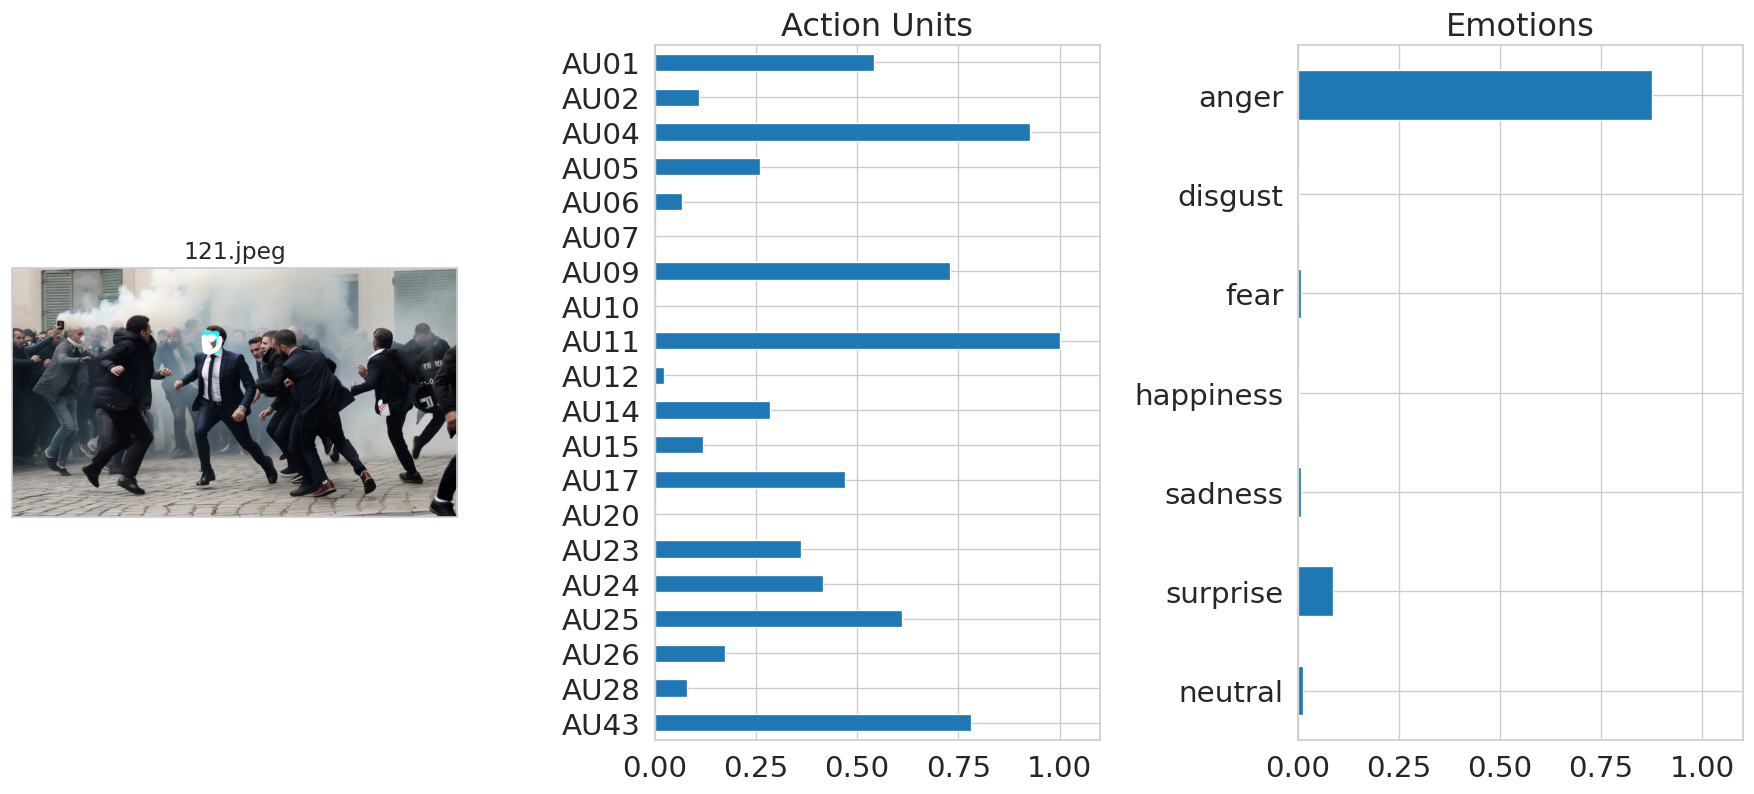


=== Incident 122 ===
[10]


FaceRectX  FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
10  638.629558  56.672069     106.664584      146.390758    0.99046   

           x_0         x_1         x_2         x_3         x_4  ...  \
10  636.473742  639.005723  642.512515  648.450567  658.653897  ...   

    Identity_507  Identity_508  Identity_509  Identity_510  Identity_511  \
10       0.03768      0.021288      0.016772     -0.038558     -0.025611   

    Identity_512                                              input  frame  \
10     -0.021518  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   

    incident_id                                         image_path  
10          122  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  

[1 rows x 688 columns]

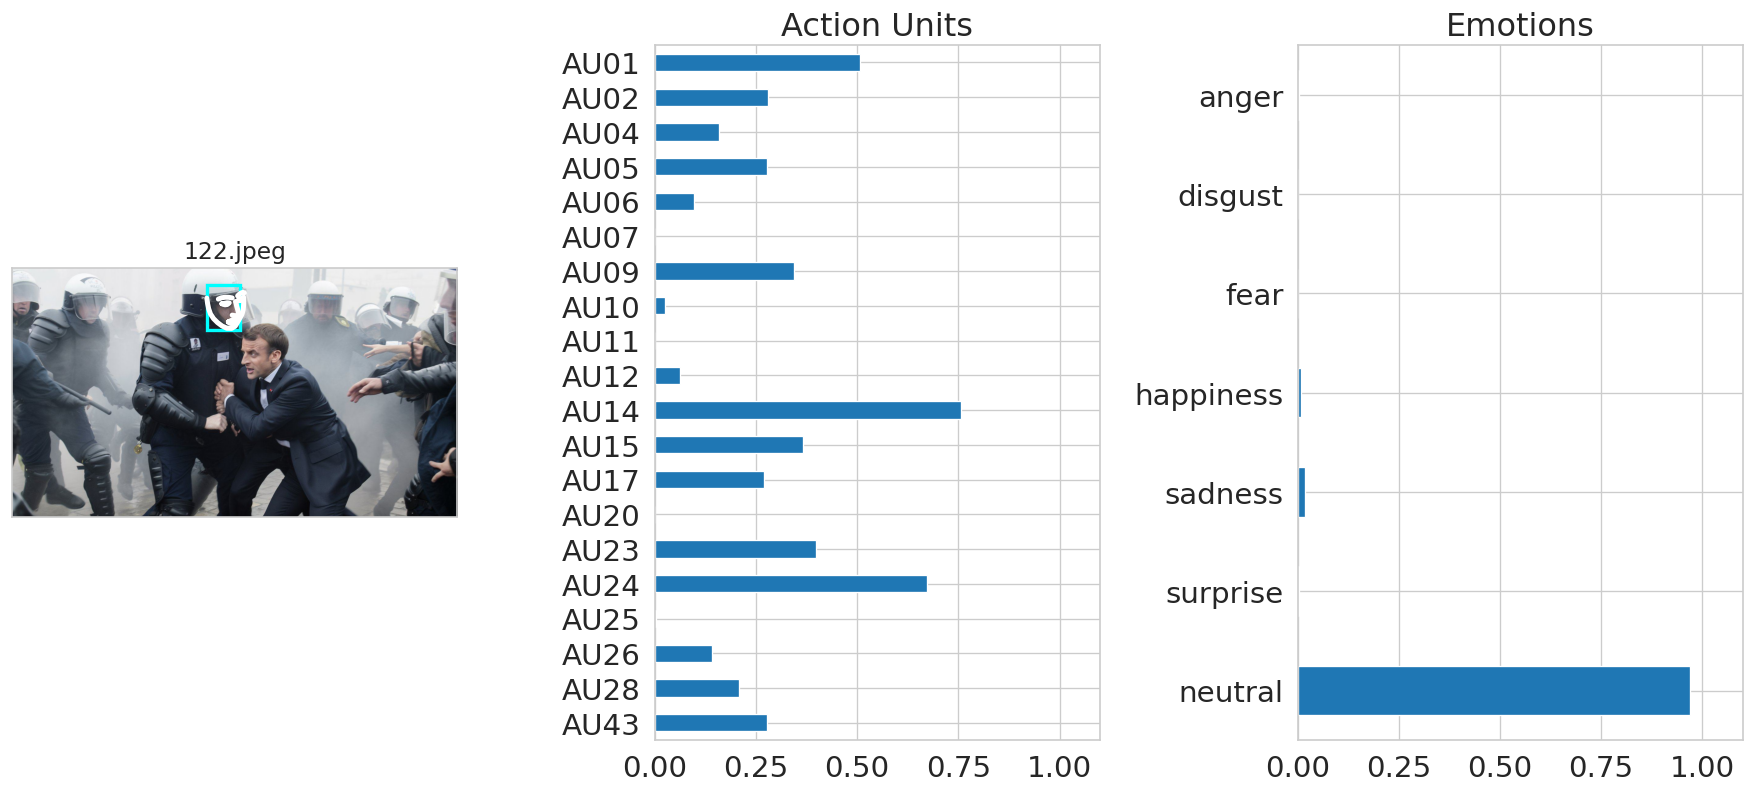


=== Incident 124 ===
[14, 15]


FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
14  445.881683  179.184311      73.179901       94.074295   0.995547   
15   35.606419  338.125641      15.453117       18.980255   0.646823   

           x_0         x_1         x_2         x_3         x_4  ...  \
14  446.726996  447.057117  448.094275  450.262219  454.500366  ...   
15   36.110834   36.897084   37.775973   38.808367   40.114166  ...   

    Identity_507  Identity_508  Identity_509  Identity_510  Identity_511  \
14      0.021572      0.025684     -0.021367       0.06726     -0.026018   
15     -0.009795     -0.004709     -0.006174      -0.02023      0.011979   

    Identity_512                                              input  frame  \
14     -0.077267  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   
15     -0.001717  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   

    incident_id                                         image_path  
14          124  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  
15          124  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  

[2 rows x 688 columns]

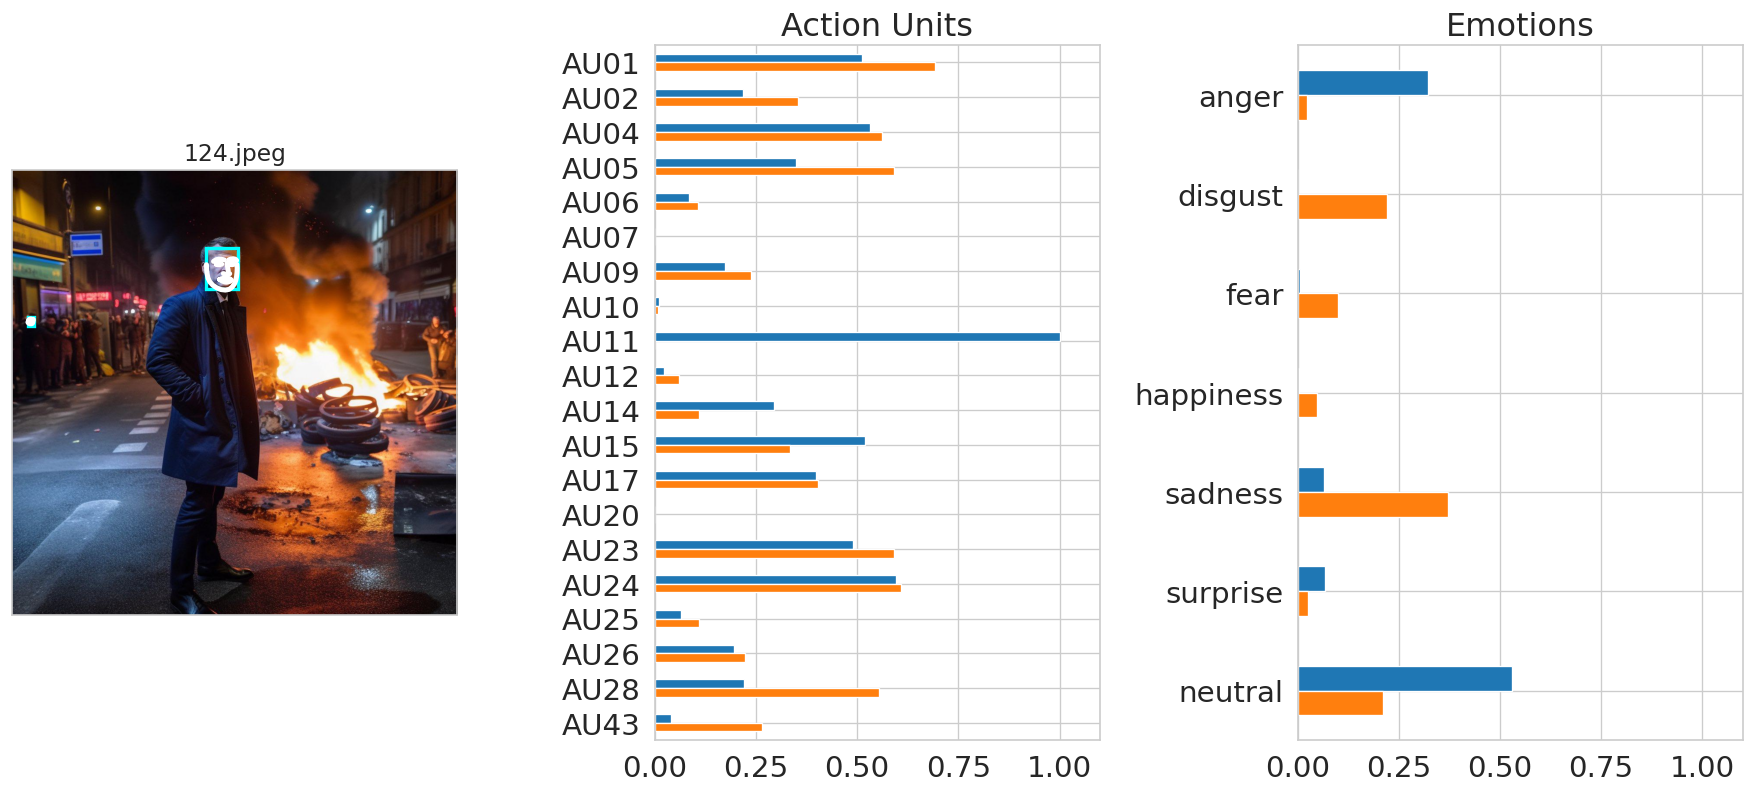


=== Incident 123 ===
[16]


FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
16  664.732389  127.748681       96.85674      151.357095    0.99904   

           x_0         x_1         x_2         x_3         x_4  ...  \
16  663.205279  663.369232  664.039813  665.667921  669.684969  ...   

    Identity_507  Identity_508  Identity_509  Identity_510  Identity_511  \
16       0.01959      0.048762     -0.013814      0.027617     -0.034975   

    Identity_512                                              input  frame  \
16     -0.101613  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   

    incident_id                                         image_path  
16          123  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  

[1 rows x 688 columns]

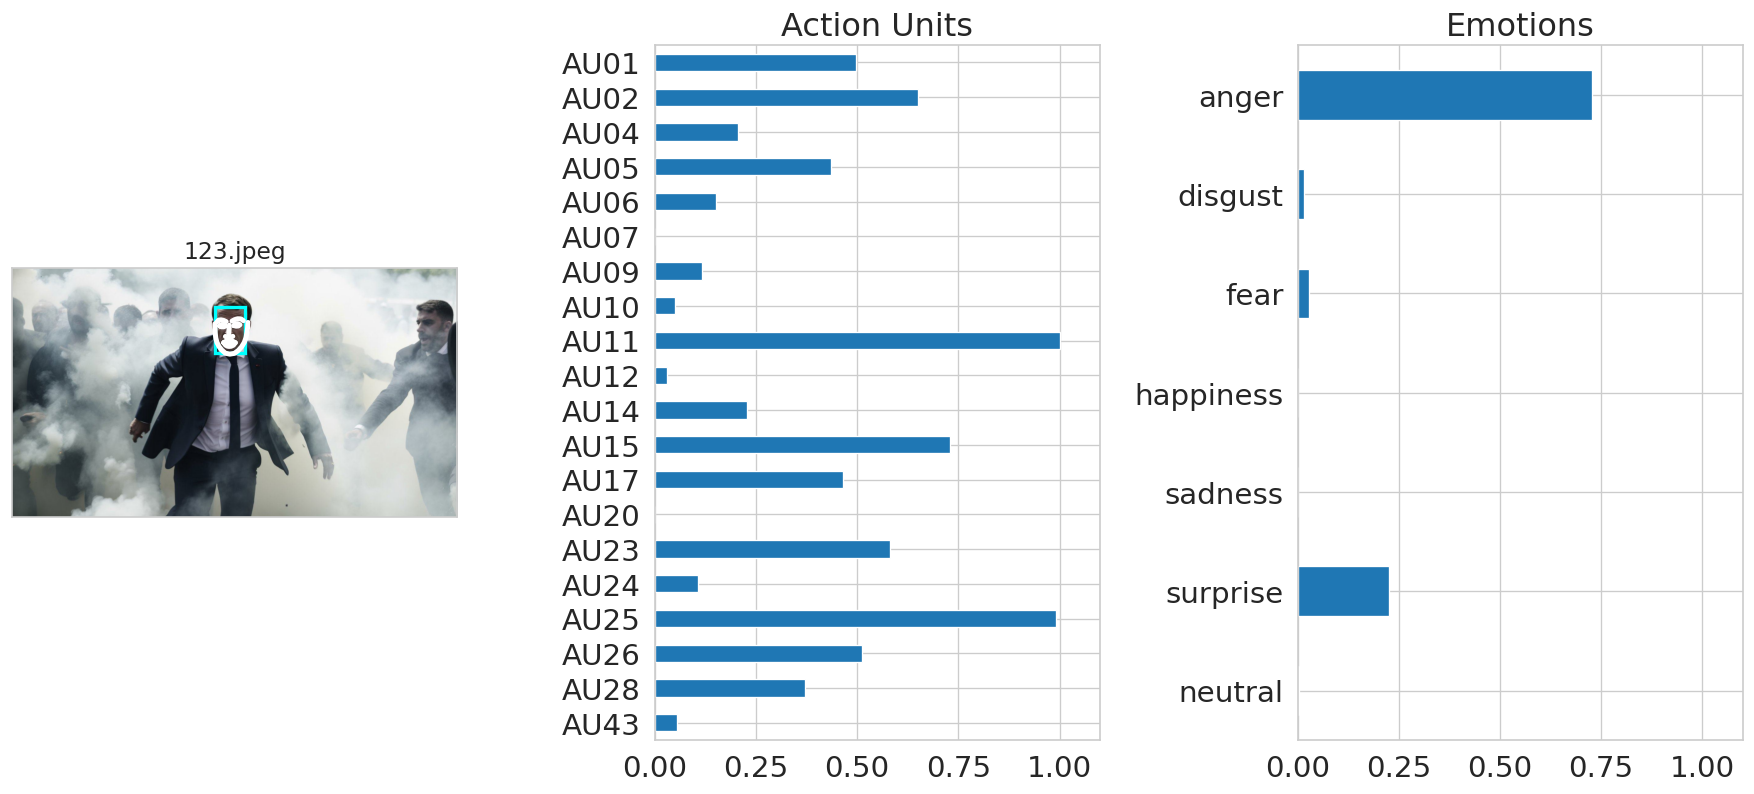


=== Incident 126 ===
[19, 20]


FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
19  466.535217  269.875427     130.427734      183.516785   0.999290   
20  921.937683  349.026123      66.880127       82.477081   0.989144   

           x_0         x_1         x_2         x_3         x_4  ...  \
19  461.338699  463.195185  466.395480  471.851122  481.598009  ...   
20  926.512857  926.704385  927.267302  929.717011  933.413831  ...   

    Identity_507  Identity_508  Identity_509  Identity_510  Identity_511  \
19      0.047359     -0.038494     -0.051061      0.044479     -0.021438   
20      0.058270     -0.003777     -0.003853     -0.024866     -0.052652   

    Identity_512                                              input  frame  \
19     -0.048197  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   
20     -0.089116  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   

    incident_id                                         image_path  
19          126  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  
20          126  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  

[2 rows x 688 columns]

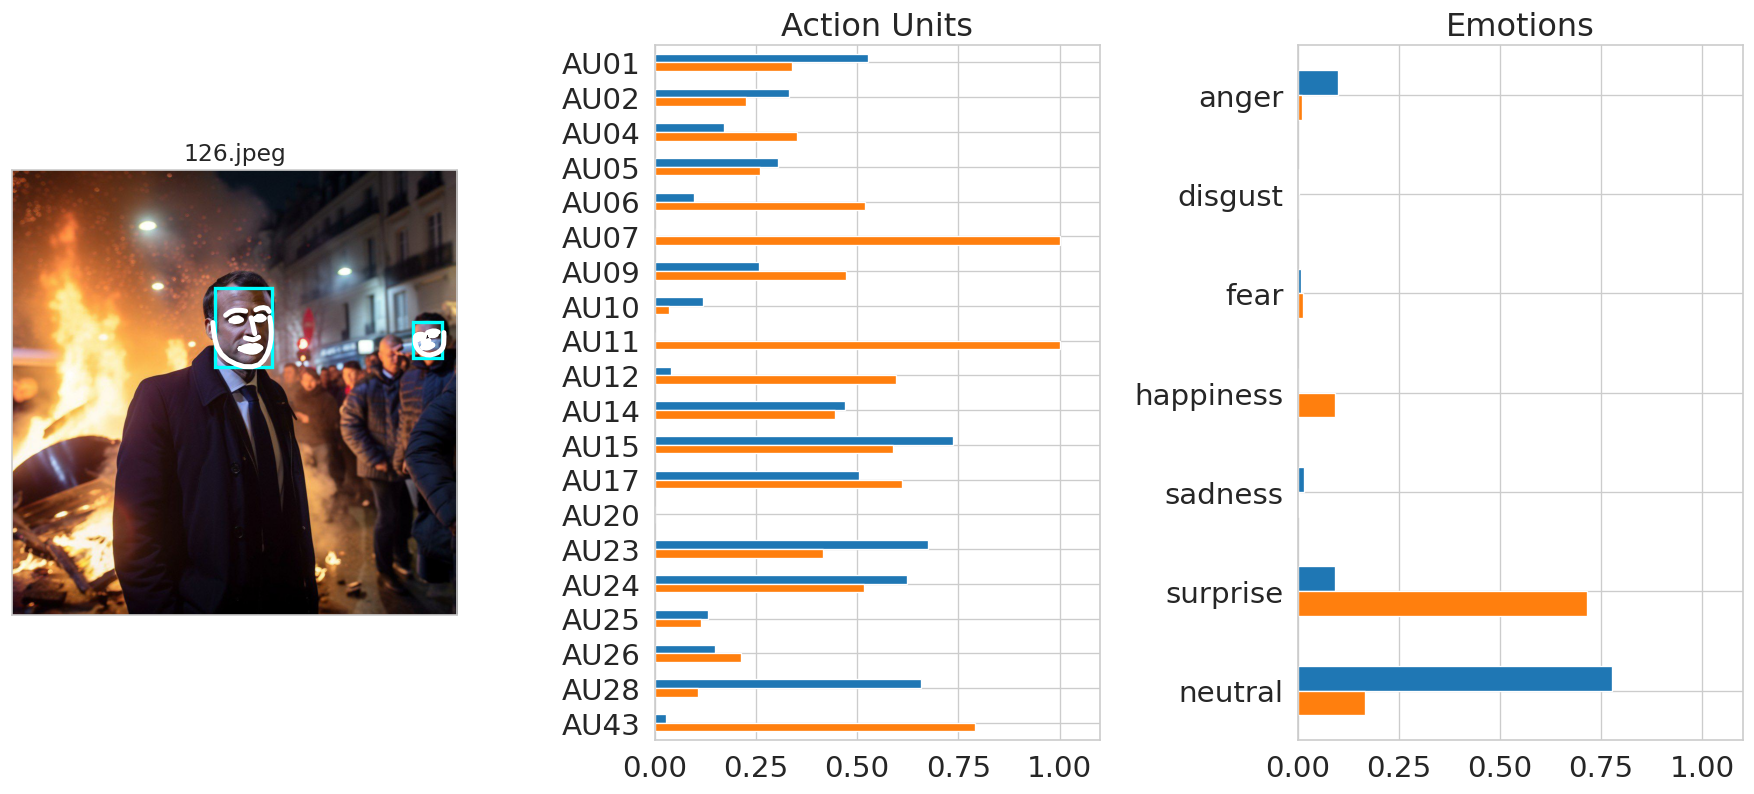


=== Incident 125 ===
[21, 22]


FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
21  468.455078  167.361847      89.940430      117.344696   0.999151   
22  881.430603  289.304932      35.691895       45.607025   0.539373   

           x_0         x_1         x_2         x_3         x_4  ...  \
21  472.689764  472.973473  473.872988  475.247785  478.534804  ...   
22  885.268715  885.152050  885.136807  885.625768  887.158936  ...   

    Identity_507  Identity_508  Identity_509  Identity_510  Identity_511  \
21      0.033215      0.069611     -0.004659      0.052399      0.000179   
22     -0.006831      0.022762     -0.010512     -0.008263      0.007742   

    Identity_512                                              input  frame  \
21     -0.077017  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   
22      0.009163  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   

    incident_id                                         image_path  
21          125  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  
22          125  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  

[2 rows x 688 columns]

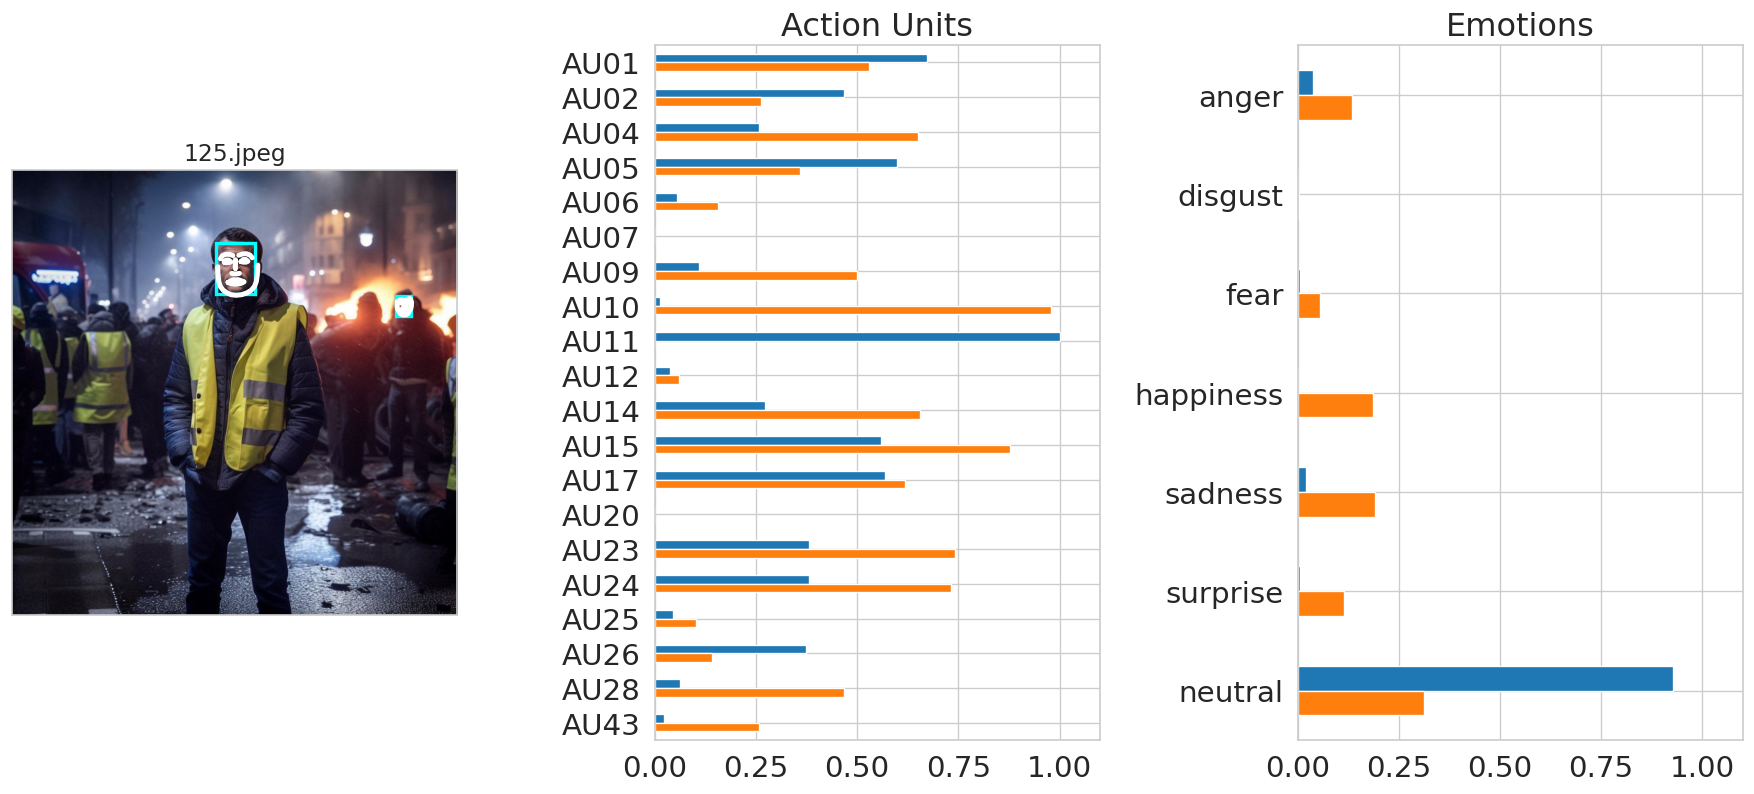


=== Incident 134 ===
[23]


FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
23  391.55011  103.631165     238.449829      351.198669   0.996891   

           x_0        x_1         x_2         x_3         x_4  ...  \
23  400.637552  398.61688  400.765964  408.249005  420.679595  ...   

    Identity_507  Identity_508  Identity_509  Identity_510  Identity_511  \
23      0.086092     -0.007942      0.006518      0.023494      0.007312   

    Identity_512                                              input  frame  \
23     -0.031943  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   

    incident_id                                         image_path  
23          134  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  

[1 rows x 688 columns]

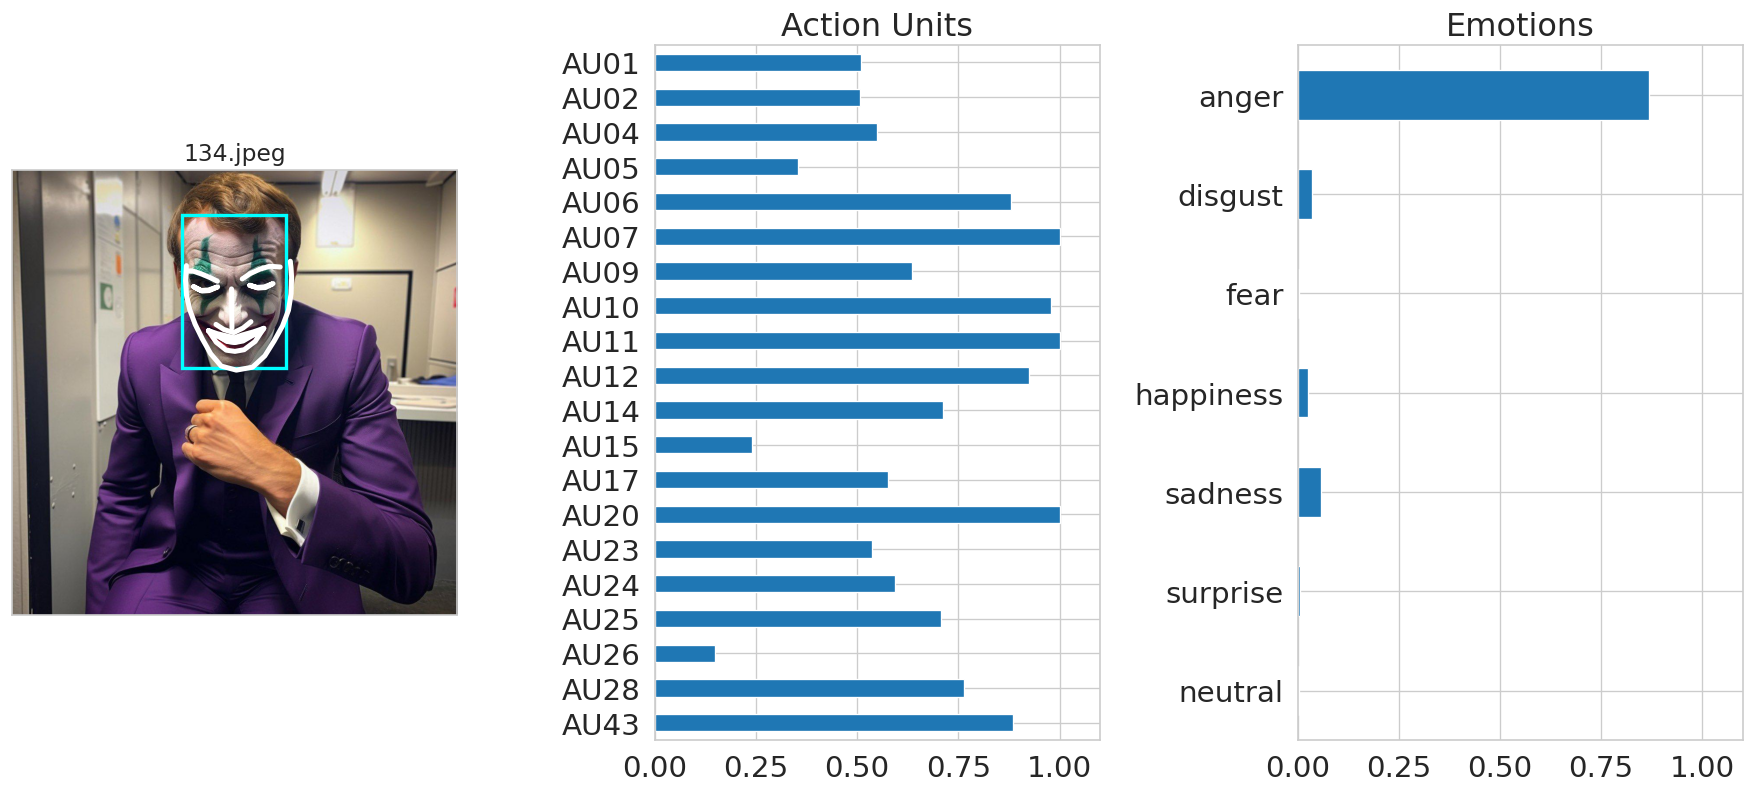


=== Incident 127 ===
[24]


FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
24  404.654114  116.290054     186.516785      261.471298   0.998414   

           x_0         x_1         x_2         x_3        x_4  ...  \
24  399.647305  394.553108  391.657963  393.269542  401.92296  ...   

    Identity_507  Identity_508  Identity_509  Identity_510  Identity_511  \
24      0.063396     -0.017835      0.050849       0.06272     -0.062116   

    Identity_512                                              input  frame  \
24     -0.056852  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   

    incident_id                                         image_path  
24          127  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  

[1 rows x 688 columns]

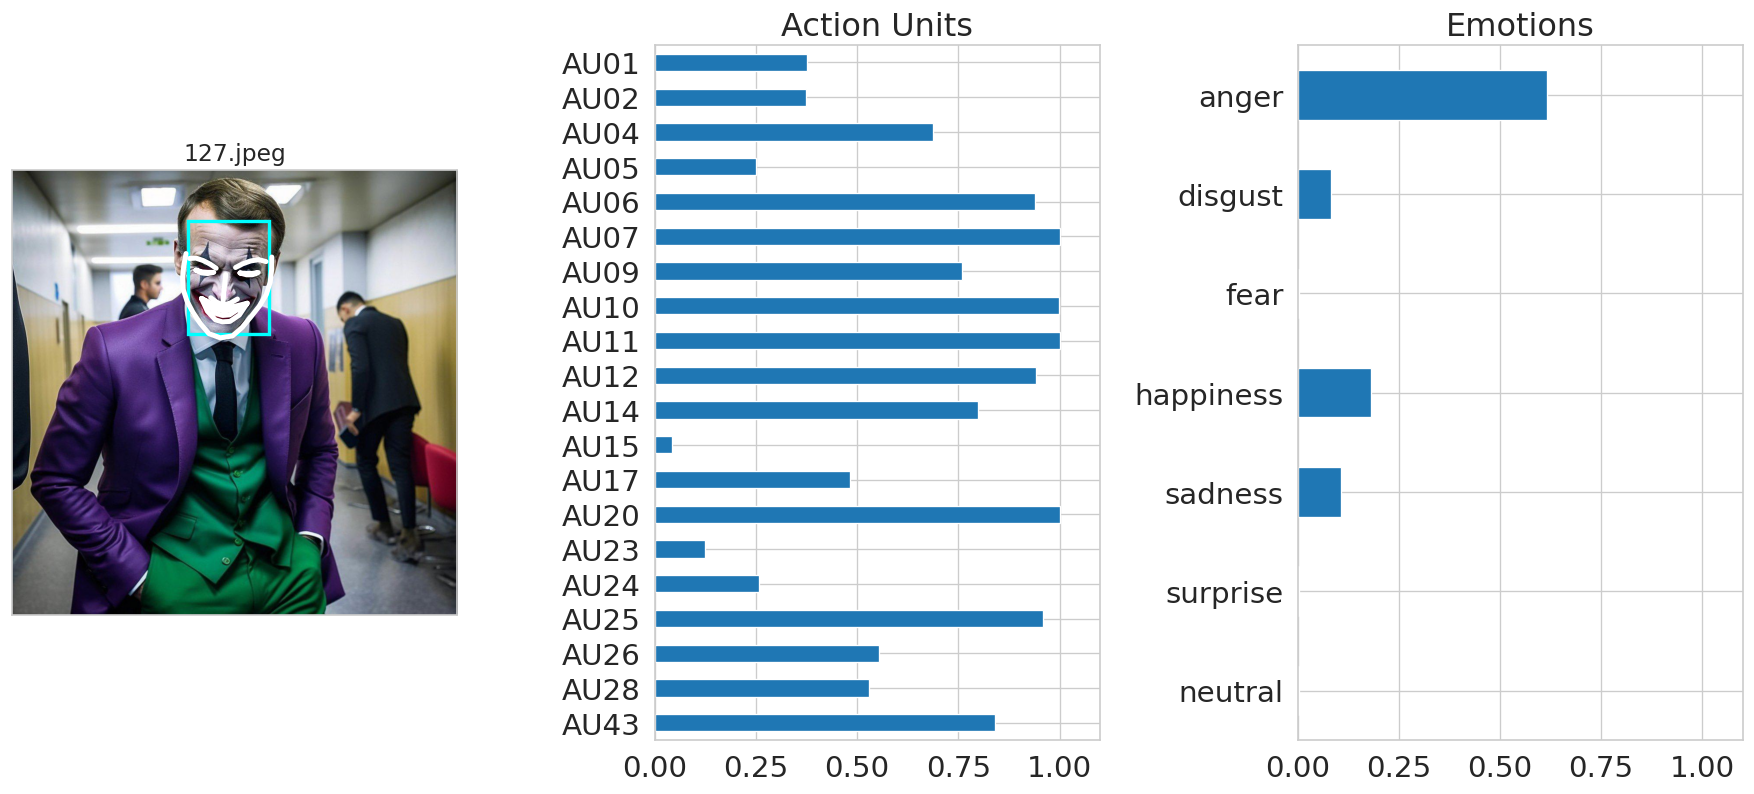


=== Incident 133 ===
[25, 26]


FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
25  349.382996  211.704605     194.364502      245.705368   0.996991   
26  318.565002   16.870541      60.816498       83.380756   0.898631   

           x_0         x_1         x_2         x_3         x_4  ...  \
25  344.119106  346.442391  351.673976  362.726691  377.401800  ...   
26  319.461986  322.284713  325.362313  329.566471  334.799356  ...   

    Identity_507  Identity_508  Identity_509  Identity_510  Identity_511  \
25      0.078489      0.043909     -0.001579      0.013350      0.000552   
26      0.024570     -0.019883      0.005673      0.025518      0.076950   

    Identity_512                                              input  frame  \
25     -0.082196  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   
26     -0.040307  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   

    incident_id                                         image_path  
25          133  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  
26          133  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  

[2 rows x 688 columns]

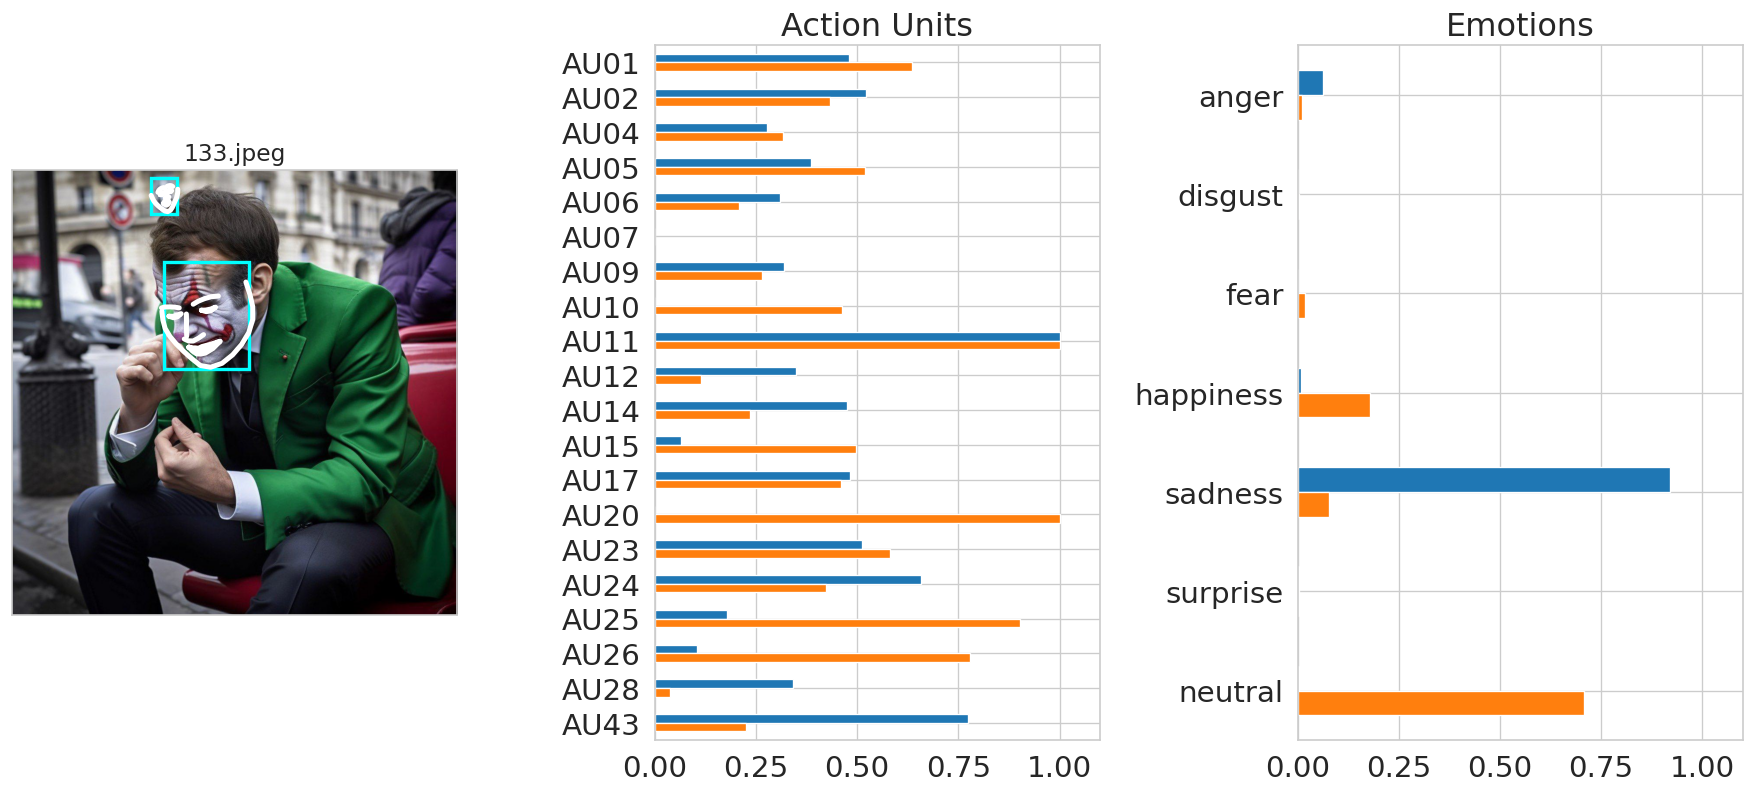


=== Incident 138 ===
[28]


FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
28  475.206451  320.438873      90.612946      116.486542   0.986631   

           x_0         x_1         x_2         x_3         x_4  ...  \
28  474.105889  473.899032  473.803317  475.184907  480.892659  ...   

    Identity_507  Identity_508  Identity_509  Identity_510  Identity_511  \
28     -0.013531      0.090241      0.016249     -0.022053      0.047921   

    Identity_512                                              input  frame  \
28     -0.002218  /content/drive/MyDrive/CSM 2025/images_no_sc/1...      0   

    incident_id                                         image_path  
28          138  /content/drive/MyDrive/CSM 2025/images_no_sc/1...  

[1 rows x 688 columns]

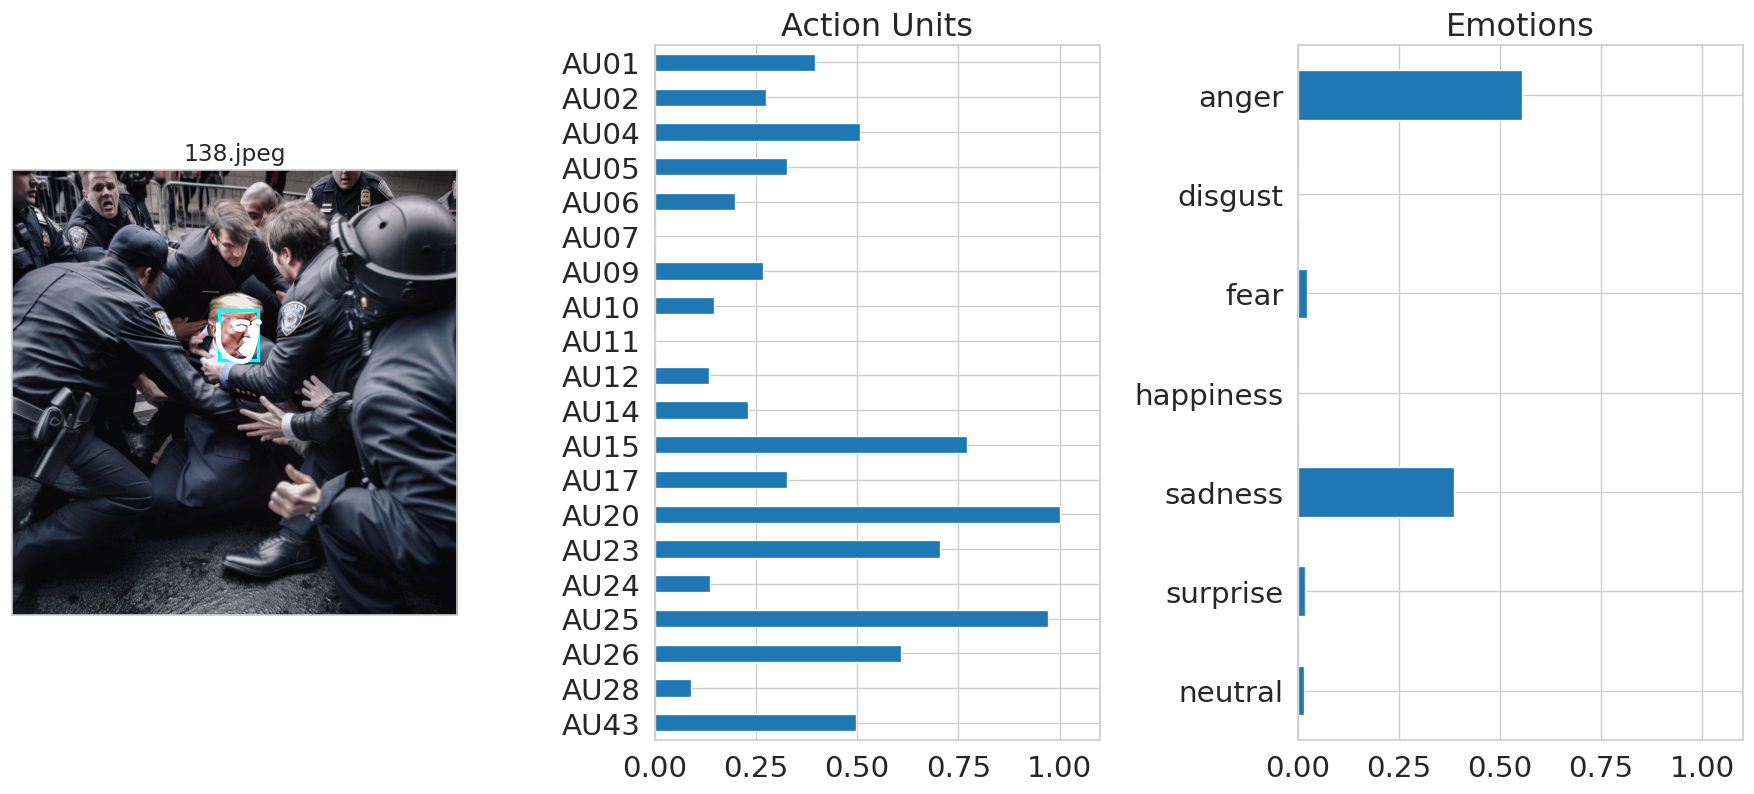

In [14]:
def plot_significant_faces(mixed_prediction, pdid_face, incident_id):
    """
    For a given incident_id, find all faces marked significant==1
    and plot only those detections.
    """
    # 1. Mask to get the index labels in mixed_prediction
    mask = (
        (pdid_face["incident_id"] == incident_id) &
        (pdid_face["significant"] == 1)
    )
    sig_idxs = pdid_face.index[mask].tolist()
    print(sig_idxs)

    if not sig_idxs:
        print(f"No significant faces found for incident {incident_id}")
        return None

    # 2. Slice the Fex by those indices
    sub_fex = mixed_prediction.loc[sig_idxs]
    display(sub_fex)

    # 3. Plot detections (only those faces)
    fig = sub_fex.plot_detections(faceboxes=True)  # draws just these boxes :contentReference[oaicite:0]{index=0}
    plt.show()
    return fig

# --- Example usage for first 20 images: ---
first_10_ids = pdid_face['incident_id'].drop_duplicates().iloc[:10].tolist()

for inc_id in first_10_ids:
    print(f"\n=== Incident {inc_id} ===")
    plot_significant_faces(res_prediction, pdid_face, inc_id)

In [15]:
emotions_columns = res_prediction.emotions.columns

# 1. Identify significant faces and their incident_ids
significant_filter = pdid_face['significant'] == 1
significant_indices = pdid_face.index[significant_filter]

if significant_indices.empty:
    print("No significant faces found. Emotion columns in pdid_master will be filled with NaN.")
    for col_name in ['dominant_emotion', 'dominant_emotion_score', 'secondary_emotion', 'secondary_emotion_score']:
        pdid_master[col_name] = np.nan
else:
    significant_incident_ids = pdid_face.loc[significant_indices, 'incident_id']

    # 2. Get emotion scores for these significant faces from res_prediction
    # Ensure all specified emotion columns exist in res_prediction
    missing_emo_cols = [col for col in emotions_columns if col not in res_prediction.columns]
    if missing_emo_cols:
        raise ValueError(
            f"The following emotion columns are not found in res_prediction: {missing_emo_cols}. "
            f"Please check the 'emotions_columns' list."
        )

    significant_emotion_data = res_prediction.loc[significant_indices, emotions_columns].copy()

    # Convert emotion scores to numeric, coercing errors to NaN
    for col in emotions_columns:
        significant_emotion_data[col] = pd.to_numeric(significant_emotion_data[col], errors='coerce')

    # Add incident_id to this data for grouping
    significant_emotion_data['incident_id'] = significant_incident_ids.values

    # 3. Group by incident_id and calculate the mean of emotion scores
    averaged_emotions_by_incident = significant_emotion_data.groupby('incident_id')[emotions_columns].mean()

    # 4. Function to determine dominant and secondary emotions
    def get_top_two_emotions(row_series):
        sorted_emotions = row_series.sort_values(ascending=False)

        # Handle cases where all scores might be NaN for a group
        if sorted_emotions.empty or sorted_emotions.isna().all():
            return pd.Series([np.nan, np.nan, np.nan, np.nan],
                             index=['dominant_emotion', 'dominant_emotion_score',
                                    'secondary_emotion', 'secondary_emotion_score'])

        dominant_emotion_label = sorted_emotions.index[0]
        dominant_score = sorted_emotions.iloc[0]

        secondary_emotion_label = np.nan
        secondary_score = np.nan

        if len(sorted_emotions) > 1:
            # Check if the second emotion score is not NaN
            if not pd.isna(sorted_emotions.iloc[1]):
                 secondary_emotion_label = sorted_emotions.index[1]
                 secondary_score = sorted_emotions.iloc[1]

        return pd.Series([dominant_emotion_label, dominant_score, secondary_emotion_label, secondary_score],
                         index=['dominant_emotion', 'dominant_emotion_score',
                                'secondary_emotion', 'secondary_emotion_score'])

    # Apply the function to each incident_id's averaged scores
    emotion_summary_df = averaged_emotions_by_incident.apply(get_top_two_emotions, axis=1).reset_index()

    if 'incident_id' in pdid_master.columns and 'incident_id' in emotion_summary_df.columns:
        pdid_master['incident_id'] = pdid_master['incident_id'].astype(str)
        emotion_summary_df['incident_id'] = emotion_summary_df['incident_id'].astype(str)
    else:
        if 'incident_id' not in pdid_master.columns:
            print("Warning: 'incident_id' column missing from pdid_master. Merge cannot proceed.")
        if 'incident_id' not in emotion_summary_df.columns:
            print("Warning: 'incident_id' column missing from emotion_summary_df. Merge cannot proceed.")

    pdid_master = pdid_master.merge(emotion_summary_df, on='incident_id', how='left')

final_emotion_cols = ['dominant_emotion', 'dominant_emotion_score', 'secondary_emotion', 'secondary_emotion_score']
for col in final_emotion_cols:
    if col not in pdid_master.columns:
        pdid_master[col] = np.nan

print("\nUpdated pdid_master with emotion summaries (first 5 rows):")
display(pdid_master[['incident_id'] + final_emotion_cols])


Updated pdid_master with emotion summaries (first 5 rows):


<ipython-input-15-93c502a1e7cc>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdid_master['incident_id'] = pdid_master['incident_id'].astype(str)


incident_id dominant_emotion  dominant_emotion_score secondary_emotion  \
0           121            anger                0.875416          surprise   
1           122          neutral                0.968989           sadness   
2           124          neutral                0.371329           sadness   
3           123            anger                0.727540          surprise   
4           126          neutral                0.472172          surprise   
..          ...              ...                     ...               ...   
315        1054            anger                0.816396           sadness   
316        1059              NaN                     NaN               NaN   
317        1060         surprise                0.909576           neutral   
318        1062            anger                0.764275           sadness   
319        1061          sadness                0.509685             anger   

     secondary_emotion_score  
0                   0.086939  
1                   0.017542  
2                   0.219012  
3                   0.224643  
4                   0.402754  
..                       ...  
315                 0.100920  
316                      NaN  
317                 0.033722  
318                 0.209507  
319                 0.340943  

[320 rows x 5 columns]

In [16]:
df_raw = df_raw.merge(pdid_master[['incident_id'] + final_emotion_cols], on='incident_id', how='left')
display(df_raw)

Unnamed: 0 report_id  date_coded  \
0            23       105  2023-11-19   
1            24       106  2023-11-19   
2            27       108  2023-11-19   
3            25       107  2023-11-19   
4            29       110  2023-11-19   
..          ...       ...         ...   
497         709       460  2025-03-06   
498         710       599  2025-03-06   
499         711       757  2025-03-06   
500         713       759  2025-03-06   
501         712       758  2025-03-06   

                                                   url  \
0    https://twitter.com/nocontextfre/status/163830...   
1    https://twitter.com/nocontextfre/status/163830...   
2    https://twitter.com/Cyphertux/status/163856597...   
3    https://twitter.com/nocontextfre/status/163830...   
4    https://twitter.com/Cyphertux/status/163858617...   
..                                                 ...   
497  https://x.com/PlanetOfMemes/status/18240700394...   
498  https://x.com/KryptoKarma2024/status/182516139...   
499  https://x.com/Trump_History45/status/183139475...   
500  https://x.com/Trump_History45/status/182891374...   
501  https://x.com/Trump_History45/status/182900803...   

                                                  file  \
0    105.jpg (https://v5.airtableusercontent.com/v3...   
1    106.jpg (https://v5.airtableusercontent.com/v3...   
2    108.jpg (https://v5.airtableusercontent.com/v3...   
3    107.jpg (https://v5.airtableusercontent.com/v3...   
4    110.jpg (https://v5.airtableusercontent.com/v3...   
..                                                 ...   
497  460.png (https://v5.airtableusercontent.com/v3...   
498  599.png (https://v5.airtableusercontent.com/v3...   
499  pdid 757.jpg (https://v5.airtableusercontent.c...   
500  pdid 759.jpg (https://v5.airtableusercontent.c...   
501  pdid 758.jpg (https://v5.airtableusercontent.c...   

                                            screenshot date_posted format  \
0                                                  NaN  2023-03-21  image   
1                                                  NaN  2023-03-21  image   
2                                                  NaN  2023-03-22  image   
3                                                  NaN  2023-03-21  image   
4                                                  NaN  2023-03-22  image   
..                                                 ...         ...    ...   
497  Screenshot 2025-03-05 at 8.45.11 PM.png (https...  2024-08-15  image   
498  Screenshot 2025-03-06 at 3.01.04 PM.png (https...  2024-08-18  image   
499  Screen Shot 2025-03-06 at 3.17.43 PM.png (http...  2024-09-04  image   
500  Screen Shot 2025-03-06 at 3.54.58 PM.png (http...  2024-08-28  image   
501  Screen Shot 2025-03-06 at 3.37.57 PM.png (http...  2024-08-29  image   

     transcript                                    summary_content  ...  \
0           NaN  President Macron is running through the street...  ...   
1           NaN  Macron is near unruly crowds who are trying to...  ...   
2           NaN  Macron is posing in a street in front of a bur...  ...   
3           NaN  President Macron is running through a cloud of...  ...   
4           NaN  Macron is standing in a street, in front of cr...  ...   
..          ...                                                ...  ...   
497         NaN  Donald Trump and Elon Musk are sitting, talkin...  ...   
498         NaN  Donald Trump is riding a horse with eagle wing...  ...   
499         NaN  It is a picture of Kamala Harris shaking hands...  ...   
500         NaN  It is an image of Donald Trump dressed up as t...  ...   
501         NaN  It is an image of Barack Obama's face in front...  ...   

                                       image_full_path is_kept_image  \
0    /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
1    /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
2    /content/drive/MyDrive/CSM 2025/images_no_sc/1...          True   
3   

In [17]:
df_raw.to_csv("/content/drive/MyDrive/CSM 2025/data/image_level_data_with_resnet_duplicates_final.csv", index=False)